# Which Hard Drives are Most Reliable? 

## Plan


The goal of our project is to determine which hard drives are most reliable by classifying and predicting early hard drive failures. 

Hypotheses:
- The 5 SMART (Self-Monitoring, Analysis and Reporting Technology) stats identified by Backblaze will indicate device hard drive failure
- Hard drive fail rates will vary by model 
- Hard drives fail rates will vary by manufacturer 

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# py files
import acquire
import prepare
import explore
import model

# data modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire

The raw data is available on Backblaze.com. For this analysis, the hard drive data from 2016 - 2019 is utilized. The files are downloaded to a local computer and then unzipped. The files are renamed to the format, "data_Qx_201x", and placed in a folder titled "data". 

The `acquire.acquire_agg_data` function reads in the data, aggregates it, and returns a Pandas dataframe. 
- Using Spark, a dataframe is created from each directory of csv files. The dataframes are concated together with their common columns. This gives a dataframe with 95 columns and 121,390,247 rows. 
- Backblaze identifies 5 SMART stats that predict hard drive failure (SMART 5, 187, 188, 197, 198). The max value of each of these stats are extracted and the dataframe is aggregated by serial number. This reduces the dataframe to 9 columns and 169,073 rows. 
- The spark dataframe is converted to a Pandas dataframe 
- The Pandas dataframe is saved as "hard_drives_smart_5.csv" for future use

This csv is linked in the README and can be downloaded. If "hard_drives_smart_5.csv" is in the working directory, `acquire.acquire_agg_data` will read from the csv instead recreating the dataframe.  

In [2]:
df = acquire.acquire_agg_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [4]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [5]:
df.describe()

,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
count,1.690730e+05,169073.000000,161975.000000,161851.000000,104189.000000,1.041790e+05,161841.000000,161841.000000
mean,6.829480e+12,0.035085,23858.714839,69.851802,5.996190,3.264823e+08,6.265940,5.913261
std,3.981103e+12,0.183996,13357.230448,1393.236993,541.364663,3.014661e+10,452.148242,447.550251
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000787e+12,0.000000,13727.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4.000787e+12,0.000000,22932.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.200014e+13,0.000000,34866.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,1.400052e+13,1.000000,90477.000000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


## Prepare

The `prepare.prepare` function reads in the dataframe and applies the following changes:
- Converts capacity column from bytes to terabytes.
- Converts max(smart_9_raw) from hours to years.
- Creates a new column for manufacturer name.
- Renames all columns appropriately.
- Reorders columns for understandability. 

In [6]:
df = prepare.prepare(df)

In [7]:
df.head()

,serial_number,manufacturer,model,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4.0,0,5.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4.0,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,4.8,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8.0,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,5.5,0.0,NaN,NaN,0.0,0.0


In [8]:
df.capacity_terabytes.value_counts()

 4.0     64886
 12.0    50729
 8.0     26108
-0.0      7031
 3.0      6789
 2.0      4678
 0.5      2607
 6.0      2411
 14.0     1302
 10.0     1255
 1.0       388
 0.3       327
 1.5       267
 0.2       210
 5.0        46
 0.1        39
Name: capacity_terabytes, dtype: int64

> Due to aggregation, we have 7,031 duplicate hard drives listed with zero capacity bytes. 

The `prepare.unique` function reads in the dataframe and removes duplicated serial numbers that were created during aggregation.

In [9]:
df = prepare.unique(df)

In [10]:
# Confirm duplicate hard drives with zero capacity have been removed
df.capacity_terabytes.value_counts()

4.0     64878
12.0    50729
8.0     26106
3.0      6789
2.0      4678
0.5      2607
6.0      2411
14.0     1302
10.0     1255
1.0       388
0.3       327
1.5       267
0.2       210
5.0        46
0.1        32
Name: capacity_terabytes, dtype: int64

## Explore

Questions to answer:
- How do we treat null values?
- What does our data look like?
    - How many different models?
    - How many different manufacturers?
    - How many different capacity sizes?
    - How many models are there for each manufacturer?
    - Are model numbers unique to capacity?
    - Are there any observations that need to be dropped (why, how many)?
- What is a failure?
    - What do failures look like?
    - How is this misleading?
    - How do we define an early failure?
- How do the lifespans of hard drives that have failed compared to hard drives that have not failed?
- How do non-zero SMART stat values compare to among fail and non-fail?
- Does the average age of drive vary by manufacturer? model number?
- Do failure rates vary by model number?
- Determine early failure cutoff by analyzing data.
- Which SMART attributes correlate most strongly with early failure? 
- Which features or combination of features correlate with early failure?

### How do we treat null values?

In [11]:
# Check for null values
df.isnull().sum()

serial_number                        1
manufacturer                         0
model                                0
capacity_terabytes                   0
failure                              0
drive_age_in_years                  60
reallocated_sectors_count          184
reported_uncorrectable_errors    57839
command_timeout                  57849
current_pending_sector_count       194
uncorrectable_sector_count         194
dtype: int64

In [12]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

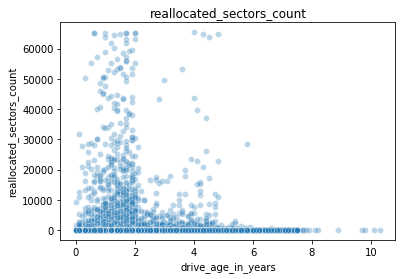

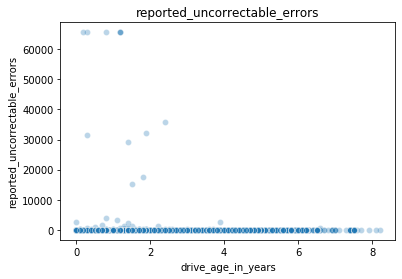

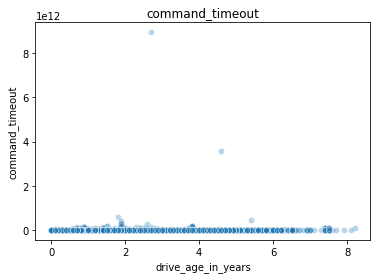

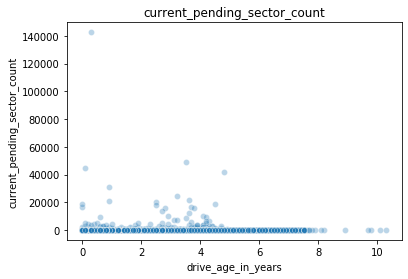

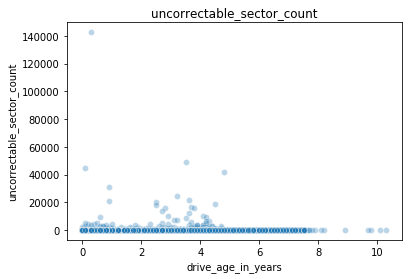

In [13]:
# Create scatterplot for SMART attributes
for col in df.columns[6:]:
    sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years, alpha=.3)
    plt.title(col)
    plt.show()

> For both "reported_uncorrectable_errors" and "command_timeout" the vast majority of values are zero. Therefore, the nulls in these columns are replaced with zeros. For the remaining nulls in "reallocated_sectors_count", "current_pending_sector_count" and "uncorrecteable_sector_count", there are less than 200 for each respective column. Therefore, those rows containing nulls are removed. This is performed in the `prepare.treat_nulls` function.

In [14]:
df = prepare.treat_nulls(df)

In [15]:
# Confirm all nulls have been removed 
df.isnull().sum()

serial_number                    0
manufacturer                     0
model                            0
capacity_terabytes               0
failure                          0
drive_age_in_years               0
reallocated_sectors_count        0
reported_uncorrectable_errors    0
command_timeout                  0
current_pending_sector_count     0
uncorrectable_sector_count       0
dtype: int64

In [16]:
df.shape

(161830, 11)

> After treating all nulls, the dataframe has 11 columns and 161,830 rows. The data can be further explored. 

### What does our data look like?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_terabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


#### How many different hard drive models in our dataset? Which are the 5 most popular?

> 97 unique hard drive models. Top 5 hard drive models include 3 Seagate and 2 Hitachi.

In [18]:
df.model.nunique()

97

In [19]:
df['model'].value_counts().head()

ST12000NM0007           38271
ST4000DM000             36156
HGST HMS5C4040BLE640    16314
ST8000NM0055            14810
HGST HUH721212ALN604    10875
Name: model, dtype: int64

#### How many different manufacturers are included in our data set?

> 6 unique manufacturers exist: Hitachi, Seagate, Western Digital, Toshiba, Unknown, and Samsung.

In [20]:
df.manufacturer.nunique()

6

In [21]:
df.manufacturer.unique()

array(['Hitachi', 'Seagate', 'Western Digital', 'Toshiba', 'Unknown',
       'Samsung'], dtype=object)

#### How many different capacity sizes exist for the hard drives in our dataset?

> 15 unique hard drive capacity sizes after rounding to the nearest tenth of a terabyte.

In [22]:
df.capacity_terabytes.nunique()

15

In [23]:
df.capacity_terabytes.unique()

array([ 4. ,  3. ,  8. ,  0.5,  6. ,  2. ,  1. ,  0.1, 12. , 10. , 14. ,
        1.5,  0.2,  0.3,  5. ])

#### How many hard drives exist for each manufacturer?

> Seagate and Hitachi are the most popular manufacturers. Samsung and Unknown only have 1 hard drive each. These hard drives should be dropped from our dataset. 

In [24]:
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Samsung,1
Seagate,105012
Toshiba,2573
Unknown,1
Western Digital,2826


#### Remove Samsung and Unknown hard drives

The `explore.remove_manufacturer` function reads in the dataframe and removes the two manufacturers with low value counts.

In [25]:
df = explore.remove_manufacturers(df)

In [26]:
# Confirm low count manufacturers have been removed
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Seagate,105012
Toshiba,2573
Western Digital,2826


#### Are model numbers unique to capacity?

> Yes, model numbers are unique to capacity. We ask this question to ensure there are not any hard drive models that have different capacities. 

In [27]:
# create new df to group models with their capacity terabytes
model_terabytes = df[['model', 'capacity_terabytes']]

In [28]:
# count unique models
model_terabytes.model.nunique()

95

In [29]:
# group unique model and unique terabytes combinations
unique_model_terabytes = len(model_terabytes.groupby(['model', 'capacity_terabytes']).count())

In [30]:
# compare the length of unique model and gigabytes combinations to the count of unique models, must equal a match.
unique_model_terabytes == model_terabytes.model.nunique()

True

#### Does the average hard drive age vary by manufacturer? By model?

In [31]:
# Average drive age by manufacturer
manufacturers = df[['manufacturer', 'drive_age_in_years']].groupby('manufacturer',sort=True).mean()
manufacturers

,drive_age_in_years
manufacturer,
Hitachi,3.057432
Seagate,2.557938
Toshiba,1.611698
Western Digital,3.765322


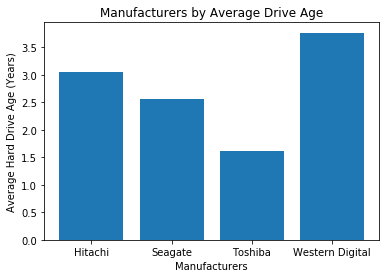

In [32]:
# Plot of Manufacturers by Average Drive Age
ax1 = plt.bar(x= manufacturers.index ,height=manufacturers.drive_age_in_years)
plt.xlabel('Manufacturers')
plt.ylabel('Average Hard Drive Age (Years)')
plt.title('Manufacturers by Average Drive Age')
plt.show()

In [33]:
# Drive age aggregated by model number and sorted. Top 10 models returned
model_avg_age = df[['model', 'drive_age_in_years']].groupby('model',sort=True).mean().sort_values('drive_age_in_years', ascending = False)
model_avg_age.head()

,drive_age_in_years
model,
WDC WD800LB,10.300000
WDC WD800BB,9.240000
Hitachi HDT725025VLA380,7.800000
WDC WD3200AAKS,6.800000
WDC WD10EACS,6.586667


Text(0.5, 1.0, 'Models by Average Drive Age')

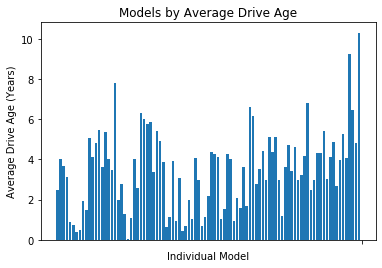

In [34]:
# Plot of Models by Average Drive Age
mod = model_avg_age.groupby('model').mean()
ax2 = plt.bar(x= mod.index ,height=mod.drive_age_in_years)
plt.xticks('')
plt.xlabel('Individual Model')
plt.ylabel('Average Drive Age (Years)')
plt.title('Models by Average Drive Age')

> Variance in drive age is seen in both the manufacturers and model numbers. The variance is more apparent amoung hard drive models.

### What is a hard drive failure?

According to Backblaze, a hard drive failure occurs when a drive stops spinning, won’t stay as a member of a RAID array, or demonstrates continuous degradation over time as informed by SMART stats and other system checks.

Because we aggregate the failure column by the max value, a "0" signifies a hard drive that has yet to fail, and a "1" signifies a hard drive that has failed. 

#### What do failures look like? 

In [35]:
df.failure.value_counts()

0    155917
1      5911
Name: failure, dtype: int64

In [36]:
(df.failure == 1).sum() / len(df)

0.03652643547470154

> Only 3.7% of all hard drives have been recorded as "failed"

#### How do the lifespans of hard drives that have failed compared to hard drives that have not failed?

In [37]:
# create new dfs with hard drives that have failed, and hard drives that have not failed 
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

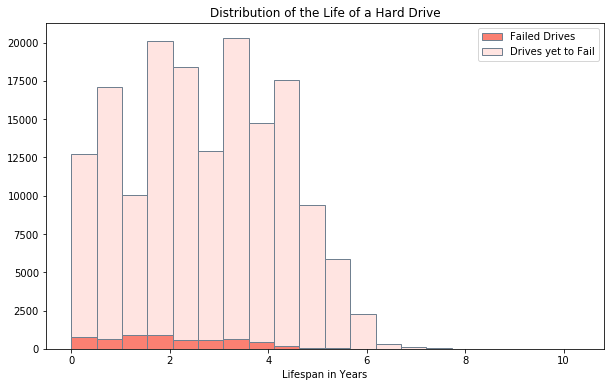

In [38]:
plt.figure(figsize=(10,6))
plt.hist([df_fails.drive_age_in_years, df_lives.drive_age_in_years], stacked=True, bins=20,
         edgecolor='slategrey', color=['salmon', 'mistyrose'])
plt.legend(["Failed Drives","Drives yet to Fail"])
plt.title("Distribution of the Life of a Hard Drive")
plt.xlabel("Lifespan in Years")
# plt.yticks([])
plt.show()

#### How is this misleading?
- Failures include not only drives that have failed, but also drives that have yet to fail but show signs of failing soon. Our goal is to determine the reliability of hard drives. Therefore, it is acceptable to classify imminently failing drives as failures. 
- Failures do not take into account the lifespan of the hard drive. It is important to realize that all hard drives, given enough time, will eventually fail. For example, a typical lifespan of a hard drive is 5 years. If a hard drive fails after 10 years of continual operation, then it should have a reliable rating, as it lasted well past it's typical lifespan. Therefore, the focus will be on drives that fail before reaching their average lifespan. 

> We will identify hard drives that are more prone to early failures.  

#### How do we define an early failure? 

The goal of the project is to determine which hard drives are more prone to early failures. Looking at the lifespan of all hard drives, a hard drive that fails within the first quartile of all life spans, is labeled as an early failure.

In [39]:
df[['drive_age_in_years']].describe()

,drive_age_in_years
count,161828.000000
mean,2.722680
std,1.524778
min,0.000000
25%,1.600000
50%,2.600000
75%,4.000000
max,10.300000


> A cut-off age of 1.6 years is utilized.

The `explore.early_failure` function creates a column in the dataframe that identifies drives that are early failures.

In [40]:
df = explore.early_failure(df,1.6)

#### Removing young non-failing hard drives

Hard drives that are currently functioning properly, but have yet reached the established cut-off age will be removed from this analysis. These hard drives have not been powered on long enough to give significant stats of a reliable drive. The `explore.old_or_fail` function drops rows containing drives that have not failed and are not older than the cut off age (1.6 years).

In [41]:
df = explore.old_or_fail(df,1.6)

In [42]:
df.shape

(121900, 12)

> After defining early failures and removing young non-failing drives, the dataframe has 12 columns and 121,900 rows. The data can be further explored. 

How many of the hard drives are identified as early failures?

In [43]:
df.early_failure.value_counts()

0    119302
1      2598
Name: early_failure, dtype: int64

In [44]:
(df.early_failure == 1).sum() / len(df)

0.021312551271534044

> Only 2.1% of hard drives are identified as early failures

#### Do early failure rates vary by model number?

In [45]:
# aggegrate by early failure, drive age, and add a total count
agg_model = df.groupby(['model']).agg({'early_failure' : 'sum', 'model' : 'count', 'drive_age_in_years':'mean'})
agg_model.rename(columns={'early_failure':'early_failures', 'model':'total_drives', 'drive_age_in_years':'average_age_in_years'}, inplace=True)

# add an early failure rate column
agg_model['early_failure_rate_percent'] = agg_model['early_failures'] / agg_model['total_drives'] * 100
agg_model.sort_values('early_failures', ascending = False)

,early_failures,total_drives,average_age_in_years,early_failure_rate_percent
model,,,,
ST12000NM0007,963,14881,1.763920,6.471339
ST4000DM000,753,35738,3.907723,2.107001
ST8000NM0055,270,14499,2.231747,1.862197
ST8000DM002,171,10041,3.008097,1.703018
HGST HMS5C4040BLE640,129,15844,3.189504,0.814188
TOSHIBA MQ01ABF050,58,545,2.149174,10.642202
ST4000DM001,34,34,0.244118,100.000000
ST500LM030,28,28,0.439286,100.000000
HGST HUH721212ALN604,25,25,0.244000,100.000000


> What is the takeaway from this graph?

#### Which SMART attributes correlate most strongly with early failure?

The five SMART stats being presented count the occurrence of different types of errors that can occur in hard drives. For each type a count of above zero indicates that a hard drive should be replaced quickly due to a risk of failure.

In [46]:
smart_stats_5 = df.columns[6:11]
smart_stats_5

Index(['reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

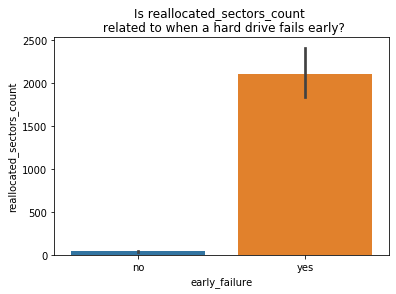

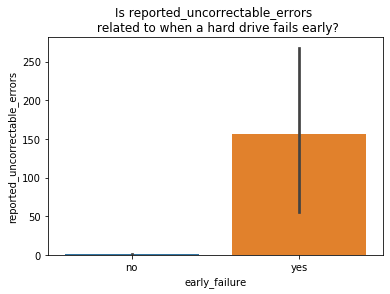

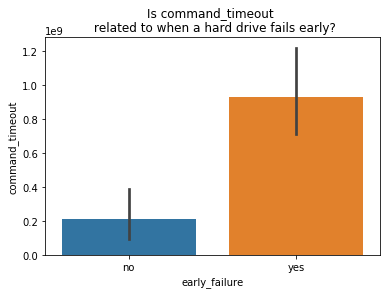

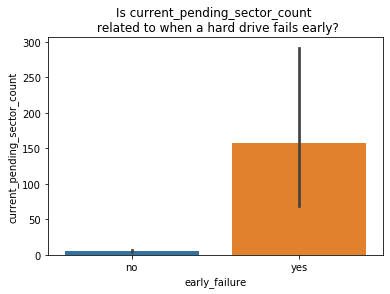

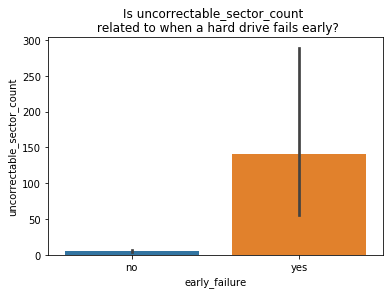

In [47]:
for stat in smart_stats_5:
    sns.barplot(df.early_failure,df[stat])
    plt.title("Is {} \n related to when a hard drive fails early?".format(stat))
    plt.xticks([0,1],["no","yes"])
    plt.show()

> Because these errors occur far more frequently in early failures than in non-early failures, all of these SMART seem to be a good indicator for early failures. 

#### Which manufacturer produces the most early failures?

In [48]:
pd.crosstab(df.manufacturer, df.early_failure)

early_failure,0,1
manufacturer,,
Hitachi,38218,196
Seagate,77604,2282
Toshiba,906,84
Western Digital,2574,36


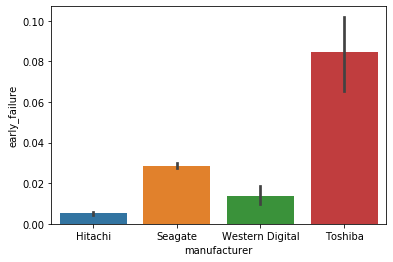

In [49]:
sns.barplot(df.manufacturer,df.early_failure)
plt.show()

> Of the four manufacturers being analyzed, Toshiba produces significantly more early failures.

#### Does drive capacity size correlate with failure rates? 

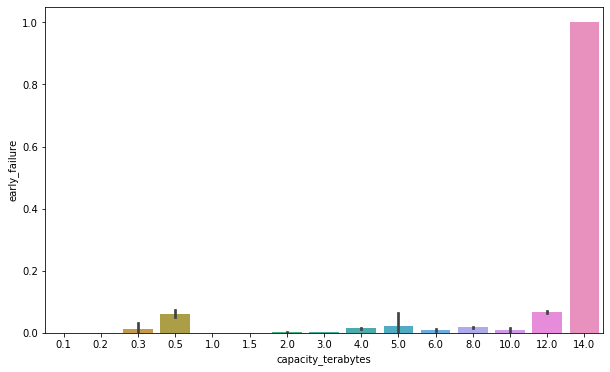

In [50]:
# sns.set(rc={'figure.figsize':(10,6)})
plt.figure(figsize=(10,6))
sns.barplot(df.capacity_terabytes,df.early_failure)
plt.show()

> Failure rate dramatically increases in drives that have a 14 terabytes capacity.

#### How do SMART stat values compare in early failed drives?

In [51]:
smart_stats_5

Index(['reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

The five SMART stats utilized in this analysis are all counters:
- reallocated_sectors_count: counts the sectors that have been found and revamped
- reported_uncorrectable_errors: counts the errors that couldnt be recovered using hardware
- command_timeout: counts the aborted operations due to timeout
- current_pending_sector_count: counts the number of unstable sectors
- uncorrectable_sector_count: counts the uncorrectable errors when reading/writing sector

In [52]:
df.groupby('early_failure').sum()[smart_stats_5]

,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
early_failure,,,,,
0,5207192.0,83682.0,2.494147e+13,596915.0,583527.0
1,5462483.0,404558.0,2.426698e+12,408722.0,366036.0


When any of these SMART stats are anything other than zero, this is a bad sign for the hard drive, regardless of the counter. Therefore, the `explore.make_binary_values` function will look at these columns, and if any contain a value greater than zero, it is replaced with a boolean True or False. This simplies the columns visuals, and will also make it simplier to feed into our model. 

In [53]:
# Make features binary
df = explore.make_binary_values(df)

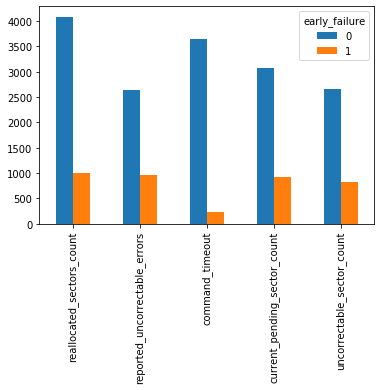

In [54]:
df.groupby('early_failure').sum()[smart_stats_5].T.plot.bar()
plt.show()

>Even though the non-early-failure hard drives have more SMART stats triggered in each column, it must be noted that the only 2% of all hard drives are early failures. 

#### Does the hard drive model affect the early failure rate?

The `model.chi2_models` function determines if a model is independent of the early fail rate by using a chi squared test. 
> H0: the hard drive model is independent of early failure rate

In [55]:
df_stat = explore.chi2_models(df)
df_stat

,model,chi2,p,signif
0,Hitachi HDS5C4040ALE630,57.7005,0.0000,True
1,ST4000DM000,0.1266,0.7220,False
2,Hitachi HDS5C3030ALA630,102.1253,0.0000,True
3,ST8000DM002,9.3981,0.0022,True
4,HGST HMS5C4040BLE640,150.7252,0.0000,True
5,ST500LM012 HN,0.1073,0.7432,False
6,ST6000DX000,18.8957,0.0000,True
7,HGST HMS5C4040ALE640,153.5531,0.0000,True
8,WDC WD30EFRX,1.3915,0.2382,False
9,WDC WD5000BPKT,0.0003,0.9870,False


> The models that have True in the 'signif' column have failed to reject the null hypothesis. Therefore, it cannot be said that these models are independent of early failure rates. 

In [56]:
len (df_stat [df_stat.signif == True])

51

In [57]:
# create a list of all the signif models
stat_sig_models = list(df_stat [df_stat.signif == True].model)

In [58]:
df.model [df.model.isin(stat_sig_models)].value_counts()

HGST HMS5C4040BLE640       15844
ST12000NM0007              14881
ST8000NM0055               14499
ST8000DM002                10041
HGST HMS5C4040ALE640        8617
Hitachi HDS5C3030ALA630     4561
Hitachi HDS722020ALA330     4503
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1911
ST10000NM0086               1204
HGST HUH728080ALE600        1046
Hitachi HDS723030ALA640     1000
TOSHIBA MQ01ABF050           545
WDC WD10EADS                 295
ST31500541AS                 264
TOSHIBA MQ01ABF050M          192
ST4000DM001                   34
ST4000DM005                   31
WDC WD20EFRX                  29
ST500LM030                    28
HGST HUH721212ALN604          25
TOSHIBA MG07ACA14TA           11
WDC WD3200BEKX                11
ST8000DM005                    7
ST12000NM0117                  5
ST4000DX002                    5
ST8000DM004                    4
HGST HUH721212ALE600           4
WDC WD10EARX                   2
WDC WD3200AAJB                 2
WDC WD1600

## Split

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121900 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    121900 non-null object
manufacturer                     121900 non-null object
model                            121900 non-null object
capacity_terabytes               121900 non-null float64
failure                          121900 non-null int64
drive_age_in_years               121900 non-null float64
reallocated_sectors_count        121900 non-null bool
reported_uncorrectable_errors    121900 non-null bool
command_timeout                  121900 non-null bool
current_pending_sector_count     121900 non-null bool
uncorrectable_sector_count       121900 non-null bool
early_failure                    121900 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 13.0+ MB


The `model.split_my_data` function takes the dataframe and first splits by features and target. 
- For the features dataframe (X), the following columns are removed: 'failure', 'early_faliure', and 'drive_age_in_years'
- For the target dataframe (y), only the 'early_failure' column is retained

Next, the function splits each dataframe (X and y) into a train and test. 
- The train size is set as 80% 
- A random state is set at 123
- The early_failure is stratified, to ensure an even split between train and test

In [60]:
X_train, X_test, y_train, y_test = model.split_my_data(df)

In [61]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97520, 9), (24380, 9), (97520, 1), (24380, 1))

In [62]:
X_train.head()

,serial_number,manufacturer,model,capacity_terabytes,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
116194,ZA1810FV,Seagate,ST8000NM0055,8.0,False,False,False,False,False
142942,Z300X20M,Seagate,ST4000DM000,4.0,False,False,False,False,False
97790,ZCH0BVX5,Seagate,ST12000NM0007,12.0,False,False,False,False,False
125503,ZCH0782T,Seagate,ST12000NM0007,12.0,False,False,False,False,False
162599,Z4D0800L,Seagate,ST6000DX000,6.0,False,False,False,False,False


The `model.encode_hot` function is used to one hot encode the manufacturer column and removes the original column.

In [63]:
# One hot encode manufacturer column
X_train, X_test = model.encode_hot(X_train, X_test, 'manufacturer')

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97520 entries, 116194 to 77819
Data columns (total 12 columns):
serial_number                    97520 non-null object
model                            97520 non-null object
capacity_terabytes               97520 non-null float64
reallocated_sectors_count        97520 non-null bool
reported_uncorrectable_errors    97520 non-null bool
command_timeout                  97520 non-null bool
current_pending_sector_count     97520 non-null bool
uncorrectable_sector_count       97520 non-null bool
Hitachi                          97520 non-null float64
Seagate                          97520 non-null float64
Toshiba                          97520 non-null float64
Western Digital                  97520 non-null float64
dtypes: bool(5), float64(5), object(2)
memory usage: 8.9+ MB


## Model 